Take the sos netcdfs, add a bunch of useful variables, save as a tidy dataset.

In [7]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units
import metpy.constants
import pint_pandas
import pint_xarray
import xarray as xr

# Inputs

In [10]:
sos_data_dir = '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240213/'
DATE_FORMAT_STR = '%Y%m%d'
# start_date = '20221201'
# end_date = dt.datetime.strftime(dt.date.today() - dt.timedelta(days=1), DATE_FORMAT_STR)
start_date = '20221130'
end_date = '20230509'
PLANAR_FIT = False

datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'h2o_1m_uw' ,'tc_1m_uw',     'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',   'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    
        'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
    'h2o_3m_uw' ,'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'h2o_10m_uw' ,'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

    'h2o_1m_ue' ,'tc_1m_ue',     'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',   'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    
        'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
    'h2o_3m_ue' ,'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'h2o_10m_ue' ,'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

    'h2o_1m_d' ,'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',   'u_u__1m_d',    'v_v__1m_d',    'w_w__1m_d',    
        'u_w__1m_d',    'v_w__1m_d',  'u_tc__1m_d',  'v_tc__1m_d',   'u_h2o__1m_d',  'v_h2o__1m_d',   'w_tc__1m_d',   'w_h2o__1m_d',
    'h2o_3m_d' ,'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'h2o_10m_d' ,'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    'h2o_2m_c' ,'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'h2o_3m_c' ,'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'h2o_5m_c' ,'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'h2o_10m_c' ,'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'h2o_15m_c' ,'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'h2o_20m_c' ,'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',

    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',    
    # Upward Facing Longwave Radiometer (tower D)
    'Rpile_in_9m_d',
    'Tcase_in_9m_d',
    # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',

    # Counts
    'counts_15m_c',
    'counts_15m_c_1',
    'counts_15m_c_2',
    'counts_10m_c',
    'counts_10m_c_1',
    'counts_10m_c_2',
    'counts_2m_c',
    'counts_2m_c_1',
    'counts_2m_c_2',
    'counts_1m_c',
    'counts_1m_c_1',
    'counts_1m_c_2',
    'counts_20m_c',
    'counts_20m_c_1',
    'counts_20m_c_2',
    'counts_3m_c',
    'counts_3m_c_1',
    'counts_3m_c_2',
    'counts_5m_c',
    'counts_5m_c_1',
    'counts_5m_c_2',

    'counts_1m_uw',
    'counts_1m_uw_1',
    'counts_1m_uw_2',
    'counts_3m_uw',
    'counts_3m_uw_1',
    'counts_3m_uw_2',
    'counts_10m_uw',
    'counts_10m_uw_1',
    'counts_10m_uw_2',
    
    'counts_1m_ue',
    'counts_1m_ue_1',
    'counts_1m_ue_2',
    'counts_3m_ue',
    'counts_3m_ue_1',
    'counts_3m_ue_2',
    'counts_10m_ue',
    'counts_10m_ue_1',
    'counts_10m_ue_2',
    
    'counts_1m_d',
    'counts_1m_d_1',
    'counts_1m_d_2',
    'counts_3m_d',
    'counts_3m_d_1',
    'counts_3m_d_2',
    'counts_10m_d',
    'counts_10m_d_1',
    'counts_10m_d_2',
]

# Download and Clean SoS data

In [11]:
# sos_ds = utils.download_sos_data(start_date, end_date, VARIABLE_NAMES, sos_download_dir, cache=True, planar_fit=False)

all_file_paths = [
    os.path.join(
        sos_data_dir,
        f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
    ) for date in datelist
]
datasets = []
for file in all_file_paths:
    ds = xr.open_dataset(file)
    # this ensures we don't access variables that aren't in this dataset, which would throw an error
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)

sos_ds = xr.concat(datasets, dim='time')    

In [12]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [13]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_h2o__1m_d',   'v_h2o__1m_d',    'w_tc__1m_d',    'w_h2o__1m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_h2o__3m_d',   'v_h2o__3m_d',    'w_tc__3m_d',    'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_h2o__10m_d',  'v_h2o__10m_d',   'w_tc__10m_d',   'w_h2o__10m_d',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_h2o__2m_c',   'v_h2o__2m_c',    'w_tc__2m_c',    'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_h2o__3m_c',   'v_h2o__3m_c',    'w_tc__3m_c',    'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_h2o__5m_c',   'v_h2o__5m_c',    'w_tc__5m_c',    'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_h2o__10m_c',  'v_h2o__10m_c',   'w_tc__10m_c',   'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_h2o__15m_c',  'v_h2o__15m_c',   'w_tc__15m_c',   'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_h2o__20m_c',  'v_h2o__20m_c',   'w_tc__20m_c',   'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'dir_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'dir_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'dir_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'dir_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'dir_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'dir_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensors
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',
    ],
    'sum' : [
        'counts_15m_c',
        'counts_15m_c_1',
        'counts_15m_c_2',
        'counts_10m_c',
        'counts_10m_c_1',
        'counts_10m_c_2',
        'counts_2m_c',
        'counts_2m_c_1',
        'counts_2m_c_2',
        'counts_1m_c',
        'counts_1m_c_1',
        'counts_1m_c_2',
        'counts_20m_c',
        'counts_20m_c_1',
        'counts_20m_c_2',
        'counts_3m_c',
        'counts_3m_c_1',
        'counts_3m_c_2',
        'counts_5m_c',
        'counts_5m_c_1',
        'counts_5m_c_2',

        'counts_1m_uw',
        'counts_1m_uw_1',
        'counts_1m_uw_2',
        'counts_3m_uw',
        'counts_3m_uw_1',
        'counts_3m_uw_2',
        'counts_10m_uw',
        'counts_10m_uw_1',
        'counts_10m_uw_2',
        
        'counts_1m_ue',
        'counts_1m_ue_1',
        'counts_1m_ue_2',
        'counts_3m_ue',
        'counts_3m_ue_1',
        'counts_3m_ue_2',
        'counts_10m_ue',
        'counts_10m_ue_1',
        'counts_10m_ue_2',
        
        'counts_1m_d',
        'counts_1m_d_1',
        'counts_1m_d_2',
        'counts_3m_d',
        'counts_3m_d_1',
        'counts_3m_d_2',
        'counts_10m_d',
        'counts_10m_d_1',
        'counts_10m_d_2',
    ]
}

In [14]:
new_data_vars = {}

for key in data_vars_processing_dict.keys():
    for var in data_vars_processing_dict[key]:
        if var in sos_ds:
            if key == 'reynolds_average':
                comp1, comp2 = var.split('__')[0].split('_')
                ending = var.split('__')[1]
                comp1_var_name = comp1+'_'+ending
                comp2_var_name = comp2+'_'+ending
                new_cov_part1 = (1/12)*(sos_ds[var] + sos_ds[comp1_var_name]*sos_ds[comp2_var_name])
                new_cov_part2 = (1/12)*sos_ds[comp1_var_name]
                new_cov_part3 = (1/12)*sos_ds[comp2_var_name]
                new_cov = new_cov_part1.resample(time='60Min').sum() - ( 
                    new_cov_part2.resample(time='60Min').sum()* new_cov_part3.resample(time='60Min').sum() 
                )
                new_data_vars[var] = new_cov
            elif key == 'average':
                new_data_vars[var] = sos_ds[var].resample(time='60Min').mean()
            elif key == 'sum':
                new_data_vars[var] = sos_ds[var].resample(time='60Min').sum()
                

In [15]:
sos_ds_30min = xr.Dataset(new_data_vars)


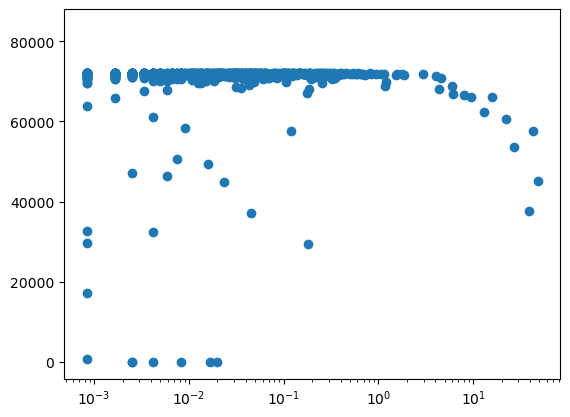

In [20]:
plt.scatter(
    sos_ds_30min['SF_avg_1m_ue'],
    sos_ds_30min['counts_3m_c_1']
)
plt.xscale('log')

# Add snow depth

Open snow depth data

In [ ]:
lidar_snowdepth_da = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/D_from_D_l6.nc").resample(time = "1440Min").mean()['surface']
lidar_snowdepth_da = lidar_snowdepth_da.interpolate_na('time')
lidar_snowdepth_da = lidar_snowdepth_da.where(lidar_snowdepth_da > 0, 0)
lidar_snowdepth_upsample_da = lidar_snowdepth_da.resample(time = '5Min', ).pad()
lidar_snowdepth_upsample_da = lidar_snowdepth_upsample_da.assign_coords(time = pd.to_datetime(lidar_snowdepth_upsample_da.time) + dt.timedelta(minutes=2.5))

lidar_snowdepth_da.plot()
lidar_snowdepth_upsample_da.plot()

In [ ]:
snowdepth_df = lidar_snowdepth_upsample_da.loc[
    sos_ds.time.min():sos_ds.time.max()
].to_dataframe()


# Option 2: Add as a variable
snowdepth_df = snowdepth_df.reset_index()
snowdepth_df = snowdepth_df[snowdepth_df.time.isin(sos_ds.time.values)]
snowdepth_df

In [ ]:
sos_ds['SnowDepth_d'] = (['time'],  snowdepth_df.surface.values)

# Add Variables, cleaning surface temperature variables before calculating other variables

## Add first sets of new variables

In [ ]:
sos_ds = variables.add_longwave_radiation(sos_ds)
sos_ds = variables.add_surface_temps(sos_ds)

### Clean $T_s$ variables 

(as of Feb 20, 2023, using NCAR's QC data release, we found a single $T_s$ outlier.)

In [ ]:
Tsurf_vars = [v for v in sos_ds.data_vars if v.startswith('Tsurf')]
Tsurf_vars

In [ ]:
for var in Tsurf_vars:
    print(sos_ds[var].max())
    print(sos_ds[var].min())

In [ ]:
for var in Tsurf_vars:
    sos_ds[var] = sos_ds[var].where(
        sos_ds[var].values < 40
    ).interpolate_na(
        dim='time', 
        method='linear'
    ).where(
        ~ sos_ds[var].isnull()
    )

In [ ]:
for var in Tsurf_vars:
    print(sos_ds[var].max())
    print(sos_ds[var].min())

## Add second set of variables

In [ ]:
sos_ds = variables.add_longwave_radiation(sos_ds)
sos_ds = variables.add_surface_temps(sos_ds)
sos_ds = variables.add_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_surface_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_tke(sos_ds)
sos_ds = variables.add_gradients_and_ri(sos_ds)
sos_ds = variables.add_obukhov_length(sos_ds)

## Add decoupling metric, from Peltola et al. (2021).

We adjust the height value for snow depth.

In [ ]:
def decoupling_metric(z, sigma_w, N):
    """Calculate the decoupling metric as described in Peltola et al (2021).

    Peltola, O., Lapo, K., & Thomas, C. K. (2021). A Physics‐Based Universal Indicator for Vertical Decoupling and Mixing Across Canopies Architectures and Dynamic Stabilities. Geophysical Research Letters, 48(5), e2020GL091615. https://doi.org/10.1029/2020GL091615
    
    Args:
        z (float): height of measurements 
        sigma_w (float): standarad deviation of w, vertical velocity
        N (float): Brunt-Vaisala frequency
    """
    # Brunt Vaisala frequency estimated using the bulk theta gradient
    # N = np.sqrt(
    #     g * (theta_e - theta_mean) / theta_mean
    # )

    Lb = sigma_w / N
    omega = Lb / ( np.sqrt(2)*z )
    return omega


In [ ]:
#######################################################################
### OLD METHOD USING GRADIENT-BASED N
#######################################################################
from metpy.calc import brunt_vaisala_frequency

sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values
pot_temps = sos_ds[[
    'Tpot_2m_c', 
    'Tpot_3m_c', 
    'Tpot_4m_c', 
    'Tpot_5m_c', 
    'Tpot_6m_c'
]].to_stacked_array(
    'z', ['time']
).values

snow_depth_values = sos_ds['SnowDepth_d']
snow_depth_values_reshaped = np.repeat(sos_ds['SnowDepth_d'].values, 5).reshape(-1, 5)

heights = np.full(pot_temps.shape,  [ 2,    3,    4,    5,    6])
heights_adjusted = heights - snow_depth_values_reshaped
brunt_vaisala_values = [ Ns[1] for Ns in 
    brunt_vaisala_frequency( 
        heights_adjusted * units("meters"),
        pot_temps * units("celsius"), 
        vertical_dim=1
    ).magnitude   
]
z = np.full(sigma_w.shape, 3) - snow_depth_values.values

# decoupling_metric(z, sigma_w, N)
print(len(z))
print(len(sigma_w))
print(len(brunt_vaisala_values))

omegas = decoupling_metric(z, sigma_w, brunt_vaisala_values)
sos_ds['omega_3m_c'] = (['time'],  omegas)
print(len(omegas))



#######################################################################
### NEW METHOD USING BULK N
#######################################################################
# sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values

# snow_depth_values = sos_ds['SnowDepth_d'].values

# air_temp_height = 3
# heights_adjusted = air_temp_height - snow_depth_values
# surf_pottemp = sos_ds['Tsurfpot_c'].values
# air_pottemp = sos_ds['Tpot_3m_c'].values
# surfacealyer_avg_pottemp = 0.5*(air_pottemp + surf_pottemp)
# bulk_brunt_vaisala_value = np.sqrt(
#     metpy.constants.earth_gravity.magnitude.item()*(air_pottemp - surfacealyer_avg_pottemp) 
#     /
#     (surfacealyer_avg_pottemp * heights_adjusted)
# )
# z = np.full(sigma_w.shape, 3) - snow_depth_values

# # decoupling_metric(z, sigma_w, N)
# print(len(z))
# print(len(sigma_w))
# print(len(bulk_brunt_vaisala_value))

# omegas = decoupling_metric(z, sigma_w, bulk_brunt_vaisala_value)
# sos_ds['omega_3m_c'] = (['time'],  omegas)

In [ ]:
import seaborn as sns
sns.histplot(sos_ds['omega_3m_c'])
plt.xlim(0,1)

# Get Tidy Dataset

In [ ]:
tidy_df = tidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

In [ ]:
tidy_df.query("variable == 'Tsurf_d'").set_index('time')['value'].plot()

In [ ]:
assert len(tidy_df.query("variable == 'omega_3m_c'")) > 0

Which variables did not get a "measurement" name assigned?

In [ ]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

# Calculate additional new variables

## Net LW and Net SW

In [ ]:
## Add Net LW variable
net_lw_radiation_values = (
        tidy_df.query("variable == 'Rlw_in_9m_d'")['value'].values
        -
        tidy_df.query("variable == 'Rlw_out_9m_d'")['value'].values
    )
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    net_lw_radiation_values,
    'Rlw_net_9m_d',
    'longwave net radiation',
    9,
    'd'
)

## Add Net SW variable
net_sw_radiation_values = (
        tidy_df.query("variable == 'Rsw_in_9m_d'")['value'].values
        -
        tidy_df.query("variable == 'Rsw_out_9m_d'")['value'].values
    )
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    net_sw_radiation_values,
    'Rsw_net_9m_d',
    'shortwave net radiation',
    9,
    'd'
)

## Net Radiation

In [ ]:
## Add Net Rad variable
net_radiation_values = (
    (
        tidy_df.query("variable == 'Rsw_in_9m_d'")['value'].values
        +
        tidy_df.query("variable == 'Rlw_in_9m_d'")['value'].values
    ) - (
        tidy_df.query("variable == 'Rsw_out_9m_d'")['value'].values
        +
        tidy_df.query("variable == 'Rlw_out_9m_d'")['value'].values
    )
)
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    net_radiation_values,
    'Rnet_9m_d',
    'net radiation',
    9,
    'd'
)

## Specific humidity

In [ ]:
for v in [
    'Tsurfmixingratio_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c',
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]:
    data = tidy_df[tidy_df.variable == v]
    specific_humidity_values = specific_humidity_from_mixing_ratio(
        xr.DataArray(data.value.values)*units('g/g')
    ).values
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        specific_humidity_values,
        v.replace('mixingratio', 'specifichumidity'),
        'specific humidity',
        data.height.iloc[0],
        data.tower.iloc[0]
    )

## Mixing ratio gradient

In [ ]:
new_variable = (
    tidy_df.query("variable == 'mixingratio_3m_c'").value.values
    - tidy_df.query("variable == 'Tsurfmixingratio_c'").value.values
) / 3

tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    new_variable,
    "q_gradient_3m_c",
    "mixing ratio gradient",
    3,
    'c'
)

## Rotated momentum flux variables

In [ ]:
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'u_w__3m_c'")['value'].values**2 
        + tidy_df.query("variable == 'v_w__3m_c'")['value'].values**2
    ),
    'u_w_rot__3m_c',
    'u_w_rot__',
    3,
    'c'
)

tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'u_w__10m_c'")['value'].values**2 
        + tidy_df.query("variable == 'v_w__10m_c'")['value'].values**2
    ),
    'u_w_rot__10m_c',
    'u_w_rot__',
    10,
    'c'
)

tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'u_w__20m_c'")['value'].values**2 
        + tidy_df.query("variable == 'v_w__20m_c'")['value'].values**2
    ),
    'u_w_rot__20m_c',
    'u_w_rot__',
    20,
    'c'
)


# Calculate Penman-Monteith and Priestley-Taylor estimates of sublimation

### Gather the data we need

In [ ]:
pyet_src = tidy_df[tidy_df.variable.isin([
    'Rnet_9m_d',
    'airdensity_3m_c',
    'Tsurfvaporpressure_c',
    'vaporpressure_3m_c',
    'T_3m_c',
    'spd_3m_c',
    'P_10m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index()
pyet_src.head(2)

In [ ]:
# From PyET code
# Equation for calculating the latent heat of vaporization from:
# Richard G Allen, Luis S Pereira, Dirk Raes, Martin Smith, and others. Crop evapotranspiration-Guidelines for computing crop 
# water requirements-FAO Irrigation and drainage paper 56. Fao, Rome, 300(9):D05109, 1998.
pyet_src['L_v estimated'] = 2.501 - 0.002361 * pyet_src['T_3m_c']

### Define function

In [ ]:
import pyet

In [ ]:
def calc_delta_alduchov(t_in_c):
# Taking the derivative of the Alduchov curve
# returns in kPa
    numerator = 37836.5*np.exp((22.587*t_in_c)/(273.86+t_in_c))
    denominator = (t_in_c + 273.86)**2
    # 0.1 to convert from millibars to kPa
    return 0.1*numerator/denominator

def calc_psychrometric_constant(C_p, P, L_v):
    # C_p in MJ/kg/˚C
    # P in kPa
    # L_v in MJ/kg
    # From wikipedia
    # https://en.wikipedia.org/wiki/Psychrometric_constant#cite_note-1
    # which cites this:
    #  Allen, R.G.; Pereira, L.S.; Raes, D.; Smith, M. (1998). Crop Evapotranspiration—Guidelines for Computing Crop Water Requirements. 
    # FAO Irrigation and drainage paper 56. Rome, Italy: Food and Agriculture Organization of the United Nations. ISBN 92-5-104219-5. Retrieved 2007-10-08.
    return C_p*P/(0.622 * L_v)

In [ ]:
C_p = 1.013 * 10 ** -3  # MJ/kg/K

def penman_monteith(
    energy_available, # MJ/m^2/day
    density_air, # kg/m^3
    vapor_pressure_surface, # kPa
    vapor_pressure_air, # kPa
    temp_air, # ˚C
    pressure, # kPa
    wind_speed, # m/s
    L_v
):
    A = energy_available
    rho_a = density_air
    e_s = vapor_pressure_surface
    e_a = vapor_pressure_air
    
    # delta = pyet.calc_vpc(temp_air)
    delta = calc_delta_alduchov(temp_air)
    y = calc_psychrometric_constant(C_p, pressure, L_v)
    r_a = pyet.calc_res_aero(wind_speed) # I should replace this with some better method for estimating atmospheric resistance - i.e. see Mahrt and Vickers, 2005, i.e. r_a = 1/(wind_speed * C_q)
    r_s = 0

    numerator = delta*A + rho_a*86400*C_p*(e_s - e_a)/r_a
    denominator = delta + y*(1 + r_s / r_a)
    return (1/L_v)*(numerator/denominator)

### Do calculations

In [ ]:
pyet_src['pm results'] = penman_monteith(
    (pyet_src['Rnet_9m_d'].to_xarray() * units("W/m^2")).pint.to("MJ/m^2/day").values,
    pyet_src['airdensity_3m_c'].values,
    (pyet_src['Tsurfvaporpressure_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    (pyet_src['vaporpressure_3m_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    pyet_src['T_3m_c'].values,
    (pyet_src['P_10m_c'].to_xarray() * units("millibars")).pint.to("kPa").values,
    pyet_src['spd_3m_c'].values,
    pyet_src['L_v estimated'].values
)

## Convert from mm/day to g/m^2/s

In [ ]:
pyet_src['pm results'] = pyet_src['pm results']/(86.4)

In [ ]:
pyet_src.set_index('time')['pm results'].plot(alpha=0.5)

In [ ]:
pyet_src.set_index('time')['pm results'].cumsum().plot(alpha=0.5)

## Add to tidy df

Fill missing timestamps with NaNs

In [ ]:
pm_values = tidy_df.query("variable == 'spd_3m_c'").merge(
    pyet_src[['time', 'pm results']],
    on='time',
    how='left'
)['pm results'].values

In [ ]:
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    pm_values,
    f'w_h2o__3m_c predicted (Penman Monteith)',
    'w_h2o_',
    3,
    'c'
)

# Calculate turbulent fluxes with MOST (my iterative solution using the MOST class)

Prepare the input data we need

In [ ]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
]
print([ v for v in tidy_df.variable.unique() if v in VARIABLES ])

# CREATE WIDE DATAFRAME
variables_df = tidy_df[tidy_df.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_c'] = variables_df['Tsurfpot_c'] + 273.15
# comes in units of g/g
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values
# comes in units of g/g,  solution requires it in units of g/kg
variables_df['specifichumidity_surface_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['Tsurfmixingratio_c'])*units('g/g')
).pint.to('g/kg').values

# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3

In [ ]:
import sys
sys.path.append('../paper1/')
from most import MOST, StabilityFunctionBrutsaert1982

most_config_dict = {
    0.00001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00001),
    0.00005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00005),
    0.0001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0001),
    0.0005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0005),
    0.001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.001),
    0.005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.005),
}

for z0, this_most in most_config_dict.items():
    L_solutions, u_friction_solutions, H_solutions, E_solutions = this_most.solve(
        variables_df['spd_3m_c'],
        variables_df['Tpot_3m_c'],
        variables_df['Tsurfpot_c'],
        variables_df['airdensity_3m_c'],
        variables_df['specifichumidity_3m_c'],
        variables_df['specifichumidity_surface_c'],
        variables_df['T_3m_c'],
        variables_df['measurement_height']
    )

    variables_df[f'L_solution_z0_{str(z0)}'] = L_solutions
    variables_df[f'u_friction_solution_z0_{str(z0)}'] = u_friction_solutions
    variables_df[f'H_solution_z0_{str(z0)}'] = H_solutions
    variables_df[f'E_solution_z0_{str(z0)}'] = E_solutions

    # convert from W/m^2 to ˚C*m/s
    variables_df[f'H_solution_z0_{str(z0)}'] = (variables_df[f'H_solution_z0_{str(z0)}']/(variables_df['airdensity_3m_c']*0.718*1000))

Add nans for the model results where there are missing timesteps (As compared to the tidy dataset of measurements)

In [ ]:
variables_df['time'] = pd.to_datetime(variables_df['time'])

variables_df = pd.merge(
    tidy_df.query("variable == 'w_h2o__3m_c'")[['time']],
    variables_df,
    on='time',
    how='outer'
)

# Add solutions to the tidy dataset

In [ ]:
# OUR SOLUTIONS
for z0 in most_config_dict.keys():
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,  
        variables_df[f'L_solution_z0_{z0}'], 
        f'L predicted ({z0})',
        'Obukhov length', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'u_friction_solution_z0_{z0}'], 
        f'u*_3m_c predicted ({z0})',
        'shear velocity', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'H_solution_z0_{z0}'], 
        f'w_tc__3m_c predicted ({z0})',
        'w_tc_', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'E_solution_z0_{z0}'], 
        f'w_h2o__3m_c predicted ({z0})',
        'w_h2o_', 
        3,
        'c'
    )

In [ ]:
src = tidy_df[tidy_df.measurement == 'w_h2o_'].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()


src['w_h2o__5m_c'].cumsum().plot(color='black', label='measured')
for col in [c for c in src.columns if 'predicted' in c]:
    src[col].cumsum().plot(label = f"predicted, z0 == {col.split(' ')[-1][1:-1]}")
plt.ylim(-30,400)
plt.legend()

# Save dataset

In [ ]:
ls -lah | grep parquet

In [ ]:
tidy_df.query("variable == 'Tsurf_d'").set_index('time')['value'].plot()

In [ ]:
if PLANAR_FIT:    
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet', index=False)
else:
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet', index=False)

In [ ]:
ls -lah | grep parquet